导入要用的库。

In [108]:
import utils
import random
import matplotlib.pyplot as plt
import math

问题参数设定。包括问题规模（城市数量）`N`，遗传算法的迭代轮数`epoch_num`， 变异概率`prob_mutate`，将这些参数设为全局参数。

In [109]:
N = 20
gen_length = N
prob_mutate = .3
individuals_num = 40
epoch_num = 500
w = 0.5
k = 2

M = int(w * N)

# 随机种子
# random.seed(20221231)

下一步是初始化问题的数据。生成城市以及距离矩阵`dmatrix`：

In [110]:
# Random Sample
cities = utils.generate_cities(N)

# HEXes sample
# cities = utils.generate_hex([0,0],1)
# cities += utils.generate_hex([0,0],1.2)

# RELOAD PARAMS
N = len(cities)
M = int(w * N)
dmatrix = utils.generate_dmatrix(cities)



下一步是构造遗传算法和遗传算法中的个体，以及遗传算法的相关操作，将其封装至类里实现逻辑分离。

In [111]:
class Individual():

    def __init__(self, gene = None) -> None:
        '''
        个体类，包含个体的核心特征`gene`和计算适应度的功能。
        '''
        if gene is not None:
            self.gene = gene 
        else:
            temp = [_ for _ in range(gen_length)]
            random.shuffle(temp)
            self.gene = temp
        self.fitness = self.calculate_fitness()

    def calculate_fitness(self):
        '''
        适应度函数表示为
        $
        \\frac{1}{\sum_{i=1}^{N-1}d_{i,i+1}}
        $
        '''
        return sum([dmatrix[self.gene[i]][self.gene[i+1]] for i in range(gen_length-1)]) \
            + dmatrix[self.gene[-1]][self.gene[0]]

class GA():
    def __init__(self,dmatrix) -> None:
        '''
        GA算法，包含GA算法的核心操作方式。

        Args:
            dmatrix: `numpy.ndrray`.表示距离矩阵。
        '''
        self.dmatrix = dmatrix
        self.individuals = []
        self.results = []
        self.best_fiteness = []
        self.best = None
        

    def mutate(self,next_gen):
        '''
        子代进行变异操作，即将基因序列中的部分片段进行反转。
        Args:
            next_gene: list[list[int]], 若干整数列表（基因序列）组成的列表（子代合集）
        '''
        for each in next_gen:
            if random.random()<prob_mutate:
                prev_gene = each.gene.copy()
                start_index = random.randint(0,gen_length -2)
                end_index = random.randint(start_index, gen_length -1)
                mutate_gene = prev_gene[start_index:end_index]
                mutate_gene.reverse()
                each.gene = prev_gene[:start_index] + mutate_gene + prev_gene[end_index:]
        self.individuals += next_gen


    def cross(self):
        '''
        杂交，从某个Generation中的Individual中随机两两不重复组合作为父母，然后从父母的片段中筛选基因片段进行重组
        然后产生两个后代。

        Args：
            return list[Individual]
        '''
        random.shuffle(self.individuals)
        next_gen = []
        for i in range(0, individuals_num, 2):
            f_gene = self.individuals[i].gene.copy()    # Father Gene
            m_gene = self.individuals[i+1].gene.copy()  # Mother Gene
            # 使用Hashmap记录顺序的对应index
            f_hash = {v:k for k,v in enumerate(f_gene)}
            m_hash = {v:k for k,v in enumerate(m_gene)}
            # 交叉位置随机生成
            start_index = random.randint(0, gen_length-2)
            end_index = random.randint(start_index, gen_length-1) 
            # 交叉
            for j in range(start_index, end_index):
                vf,vm = f_gene[j], m_gene[j]
                pos_f, pos_m = f_hash[vm], m_hash[vf]
                f_gene[j], f_gene[pos_f] = f_gene[pos_f], f_gene[j]
                m_gene[j], m_gene[pos_m] = m_gene[pos_m], m_gene[j]
                # 更新Hashmap
                f_hash[vf], f_hash[vm] = pos_f, j
                m_hash[vf], m_hash[vm] = j, pos_m
            next_gen.append(Individual(f_gene))
            next_gen.append(Individual(m_gene))
        return next_gen

    def select_next_gen(self):
        '''
        锦标赛选择下一代。
        '''

        group_num = 10 #int(.1 * individuals_num)  # 小组数
        group_size = 10 #int(.1 * individuals_num)  # 每小组人数
        group_winner = individuals_num // group_num  # 每小组获胜人数
        winners = []  # 锦标赛结果
        for i in range(group_num):
            group = []
            for j in range(group_size):
                # 随机组成小组
                player = random.choice(self.individuals)
                player = Individual(player.gene)
                group.append(player)
            group = sorted(group,key=lambda x:x.fitness, reverse=False)
            # 取出获胜者
            winners += group[:group_winner]
        self.individuals = winners

    def step(self):
        '''
        迭代过程。
        '''
        # 杂交
        next_gen = self.cross()
        # 变异
        self.mutate(next_gen)
        # 优胜劣汰
        self.select_next_gen()

        for individual in self.individuals:
            if individual.fitness < self.best.fitness:
                self.best = individual

    def train(self, epoch_num):
        '''
        训练过程的集成。
        Args:
            INPUT: epoch_num: 训练的轮数
            OUTPUT:
                self.results: 最优解
                self.best_fiteness: 适应度历史
        '''
        self.individuals = [ Individual() for _ in range(individuals_num)]
        self.best = self.individuals[0]
        for epoch in range(epoch_num):
            self.step()
            result = self.best.gene.copy()
            result.append(result[0])

            self.results.append(result)
            self.best_fiteness.append(self.best.fitness)
        
        return self.results, self.best_fiteness

下面开始求解问题：

In [112]:
algorithm = GA(dmatrix)
result_list, fitness_list = algorithm.train(epoch_num)

结果展示一下：

C:\Users\10706\AppData\Local\Temp\ipykernel_13816\169415492.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


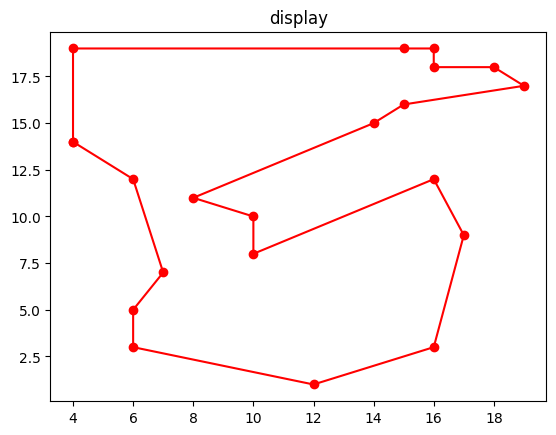

In [113]:
result = result_list[-1]
result_pos_list = [cities[each] for each in result]

fig = plt.figure()
x_,y_ = zip(*result_pos_list)
plt.plot(x_, y_, 'o-r')
plt.title("display")
fig.show()

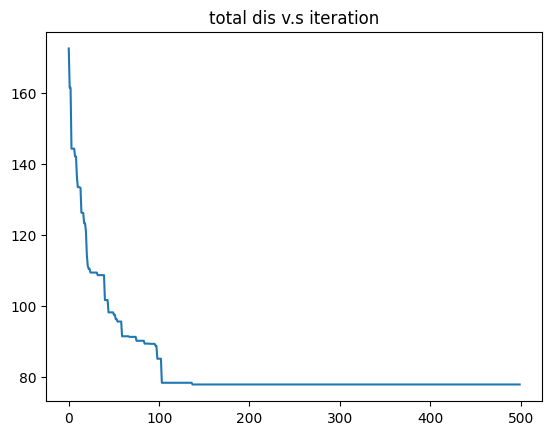

In [114]:
plt.plot(fitness_list)
plt.title("total dis v.s iteration")
plt.show()

In [115]:
d_list = [dmatrix[result[i]][result[i+1]] for i in range(len(result) -1)]
bike_index = sorted(range(len(d_list)),key = lambda x: d_list[x], reverse=True)
usebike = [str(result[k])+" -> "+str(result[k+1]) for k in bike_index]
d_list = sorted(d_list,reverse=True)

In [116]:
total_time = (1/k) * sum(d_list[:M]) + 1 * sum(d_list[M:])
print("Travel Order: {}".format(result).replace(',',' -> '))
print("Total time used : {}".format(total_time))
print("Use Bike In Road: {}".format(usebike[:M]))

Travel Order: [3 ->  2 ->  19 ->  15 ->  1 ->  4 ->  16 ->  5 ->  17 ->  6 ->  8 ->  18 ->  14 ->  9 ->  13 ->  0 ->  10 ->  11 ->  12 ->  7 ->  3]
Total time used : 47.97202105792663
Use Bike In Road: ['12 -> 7', '17 -> 6', '18 -> 14', '1 -> 4', '16 -> 5', '2 -> 19', '7 -> 3', '4 -> 16', '9 -> 13', '5 -> 17']
